# Single Raw Aspect Modelling

In [131]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [132]:
PATH    = "./../data/single_raw.csv"

In [133]:
data = pd.read_csv(PATH, usecols=["ProductId", "Score", "Text"])

In [134]:
data.head()

,ProductId,Score,Text
0,0,1,advertise product arrive label jumbo salt pean...
1,1,4,delight say confection around century light pi...
2,2,4,nice taffy get wild hair taffy order five poun...
3,4,5,strawberry twizzler yummy strawberry twizzler ...
4,4,5,lot twizzler expect daughter love twizzler shi...


In [135]:
# Return matrix of tfidf for each configuration of documents (rows) and words (columns)
vectorizer  = TfidfVectorizer()
word_sparse = vectorizer.fit_transform(data["Text"])
features    = vectorizer.get_feature_names_out()
columns     = np.concatenate([["ProductId"], features])

In [136]:
product_ids = data["ProductId"].values.reshape(-1,1)
product_ids_sparse = csr_matrix(product_ids)

In [137]:
x = hstack([product_ids, word_sparse])
y = data["Score"].values - 1

In [138]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

In [139]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(83397, 52006)
(83397,)
(20850, 52006)
(20850,)


## Neural Network Classifier

In [140]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 5

epoch_no    = 100
batch_size  = 512

In [141]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [142]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [143]:
# Add layers and activation function to neural network
nn_class    = tf.keras.Sequential()

nn_class.add(Input(shape=(input_dim,)))
nn_class.add(Dense(n_neurons_1, activation='relu'))
nn_class.add(Dense(n_neurons_2, activation='relu'))
nn_class.add(Dense(n_neurons_3, activation='relu'))
nn_class.add(Dense(output_dim, activation='sigmoid'))

# Configure loss function, gradient descent, and evaluation metrics
nn_class.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [144]:
nn_class.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 517ms/step - accuracy: 0.3730 - loss: 12.4942
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 479ms/step - accuracy: 0.4996 - loss: 3.6000
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 539ms/step - accuracy: 0.6604 - loss: 1.2211
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.5801 - loss: 2.1729
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.6457 - loss: 1.3341
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 518ms/step - accuracy: 0.6567 - loss: 1.1602
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 527ms/step - accuracy: 0.6392 - loss: 1.2953
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 492ms/step - accuracy: 0.6579 - loss: 1.0848
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - accuracy: 0.6455 - loss: 1.1281
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.6090 - loss: 1.5242
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.6619 - loss: 1.0794
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 528ms/step - accuracy: 0.6623 - loss: 1.0466
Epoch 13/100
163/16

## Neural Network Regressor

In [145]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 1

epoch_no    = 100
batch_size  = 512

In [146]:
# Add layers and activation function to neural network
nn_reg    = tf.keras.Sequential()

nn_reg.add(Input(shape=(input_dim,)))
nn_reg.add(Dense(n_neurons_1, activation='relu'))
nn_reg.add(Dense(n_neurons_2, activation='relu'))
nn_reg.add(Dense(n_neurons_3, activation='relu'))
nn_reg.add(Dense(output_dim, activation='linear'))

# Configure loss function, gradient descent, and evaluation metrics
nn_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

In [147]:
reg_loss = nn_reg.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 743ms/step - loss: 338.0600 - mae: 8.3906
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 721ms/step - loss: 6.1394 - mae: 2.0342
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - loss: 8.0194 - mae: 2.0943
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - loss: 3.3989 - mae: 1.5393
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 613ms/step - loss: 2.9735 - mae: 1.4433
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - loss: 4.4722 - mae: 1.6631
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 647ms/step - loss: 2.5854 - mae: 1.3411
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - loss: 2.3032 - mae: 1.2679
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - loss: 2.0421 - mae: 1.1913
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - loss: 3.0919 - mae: 1.4234
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 667ms/step - loss: 1.8634 - mae: 1.1349
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649

In [148]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
0.8219906687736511


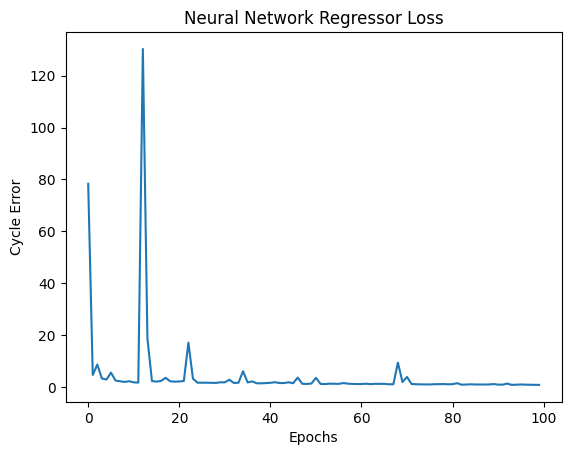

In [149]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

plt.plot(reg_loss.history['loss'])
plt.title("Neural Network Regressor Loss")
plt.xlabel("Epochs")
plt.ylabel("Cycle Error")
plt.show()

In [150]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)  # You can tune alpha later
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

aspect_names = columns  # or provide aspect column names directly
coefficients = ridge.coef_

# Get top contributing aspects
top_positive = sorted(zip(coefficients, aspect_names), reverse=True)[:10]
top_negative = sorted(zip(coefficients, aspect_names))[:10]

print("Top Positive Aspects:")
for coef, name in top_positive:
    print(f"{name}: {coef:.4f}")

print("\nTop Negative Aspects:")
for coef, name in top_negative:
    print(f"{name}: {coef:.4f}")

aspect_map = dict(zip(columns, coefficients))
for key, value in aspect_map.items():
    print(key, value)

MSE: 0.7955
Top Positive Aspects:
great: 2.9586
good: 2.3326
excellent: 2.2751
perfect: 2.0152
wonderful: 1.7767
awesome: 1.7668
outstanding: 1.7246
delicious: 1.7246
heaven: 1.7146
superb: 1.7045

Top Negative Aspects:
disappointing: -4.9707
disappointment: -4.8145
awful: -4.4721
poor: -4.2939
yuck: -4.0007
disgust: -3.9751
tasteless: -3.9099
terrible: -3.8180
horrible: -3.7973
rip: -3.7373
ProductId -8.137988914973998e-08
00 -0.5974291776889162
000 -0.3043348814899659
0000soo 0.02821493010341178
0002251337 0.012943843308489213
001 0.02486177572320283
0023 0.013633791874060134
003 0.0
004 0.045105697426288185
0060187654 0.009024712016786965
0060721855 0.02486177572320283
0061658197 0.035086088439773816
008 -0.03503694998829805
0099 -0.03136309399457934
00gr 0.028629267982989898
00pm 0.0851443093715992
01 -0.5417917577506918
01069 -0.015601250049387146
012 0.0
015 0.031158410250313674
0199535892 -0.008879746695489361
02 -0.1431323455203881
02027c 0.04068706160919703
025913 0.0200345971

In [151]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

print("Top Contributing Aspects:")
for idx in sorted_idx[:10]:
    print(f"{aspect_names[idx]}: {importances[idx]:.4f}")

MSE: 0.8372
Top Contributing Aspects:
bad: 0.0461
great: 0.0452
good: 0.0322
love: 0.0266
delicious: 0.0251
disappointed: 0.0170
waste: 0.0165
excellent: 0.0147
favorite: 0.0137
return: 0.0137


652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.59      0.50      0.54      1999
           1       0.00      0.00      0.00      1126
           2       0.06      0.00      0.00      1415
           3       0.25      0.00      0.00      2738
           4       0.71      1.00      0.83     13572

    accuracy                           0.70     20850
   macro avg       0.32      0.30      0.27     20850
weighted avg       0.55      0.70      0.59     20850



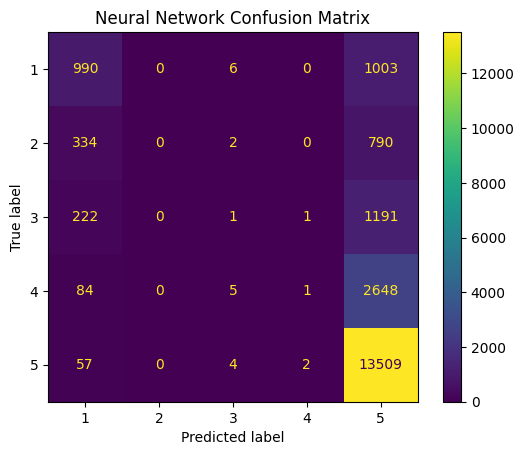

In [152]:
# Neural Network Classification
nn_pred = nn_class.predict(x_test)
nn_pred = [np.argmax(arr) for arr in nn_pred]
print(classification_report(y_pred=nn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("Neural Network Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.19      0.12      0.15      1999
           1       0.09      0.03      0.04      1126
           2       0.09      0.04      0.05      1415
           3       0.17      0.09      0.12      2738
           4       0.67      0.85      0.75     13572

    accuracy                           0.58     20850
   macro avg       0.24      0.23      0.22     20850
weighted avg       0.49      0.58      0.52     20850



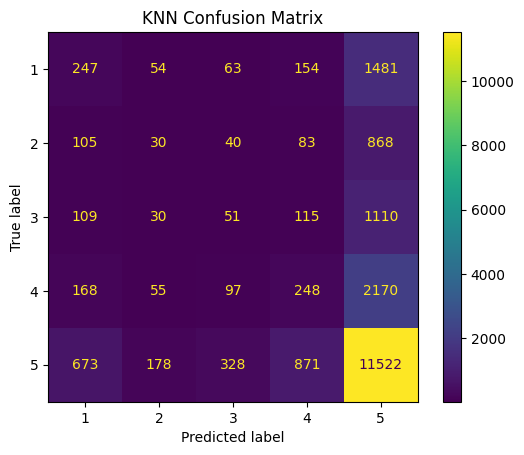

In [153]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
print(classification_report(y_pred=knn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("KNN Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.37      0.51      1999
           1       0.99      0.14      0.24      1126
           2       0.85      0.14      0.24      1415
           3       0.97      0.14      0.24      2738
           4       0.71      1.00      0.83     13572

    accuracy                           0.72     20850
   macro avg       0.87      0.36      0.41     20850
weighted avg       0.78      0.72      0.65     20850



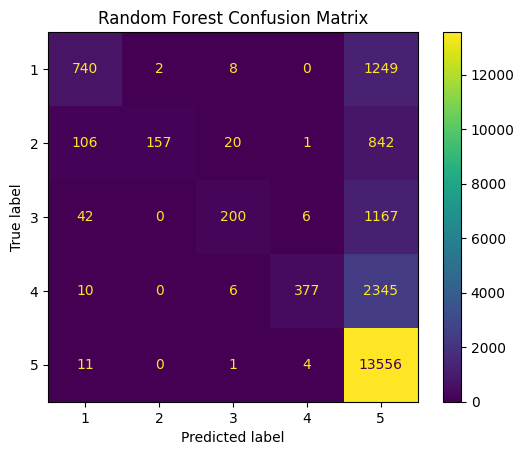

In [154]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classficication
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_pred=rf_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()